<a href="https://colab.research.google.com/github/andrea-gasparini/machine-learning-homeworks/blob/master/homework2/homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning - Homework 2

## Libraries import

In [1]:
import numpy as np
import tensorflow as tf
import keras
import os
import sys

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import image, pyplot as plt
from sklearn.model_selection import train_test_split

## Load data

To run this notebook on Google Colab it's necessary to zip the dataset folder as `dataset.zip` and place it in the root of Google Drive, or set the `colab_dataset_dir` variable with the right path to it.

In [2]:
colab_dataset_dir = "/content/gdrive/MyDrive/dataset.zip"

if 'google.colab' in sys.modules:    
    from google.colab import drive

    drive.mount("/content/gdrive")

    assert os.path.isfile(colab_dataset_dir), "dataset zip file not found in " + colab_dataset_dir

    !cp {colab_dataset_dir} "/content/"
    !unzip -uq "/content/dataset.zip"

    !pip install split-folders  

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Split the dataset in training and validation sets

In [3]:
import splitfolders

dataset_dir = "./dataset/"
splitted_dataset_dir = "./splitted_dataset/"

splitfolders.ratio(dataset_dir, output=splitted_dataset_dir, seed=42, ratio=(.7, .3), group_prefix=None)

train_dir = splitted_dataset_dir + "train/"
val_dir = splitted_dataset_dir + "val/"

Copying files: 8221 files [00:01, 5431.03 files/s]


### Define ImageDataGenerators for both sets

In [4]:
batch_size = 32
img_height = img_width = 250
color_mode = "rgb"

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

val_datagen = ImageDataGenerator(rescale=1. / 255)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

class_names = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %class_names)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d validation samples from %d classes.' %(val_generator.n,val_generator.num_classes))

Found 5750 images belonging to 8 classes.
Found 2471 images belonging to 8 classes.
Image input (250, 250, 3)
Classes: ['Breadsticks', 'Cereals_box', 'Cocoa_drink_bottle', 'Nitrile_Gloves', 'Pears', 'accent_plate', 'paper_bag', 'plastic_fork']
Loaded 5750 training samples from 8 classes.
Loaded 2471 validation samples from 8 classes.


## Show 10 images from the dataset

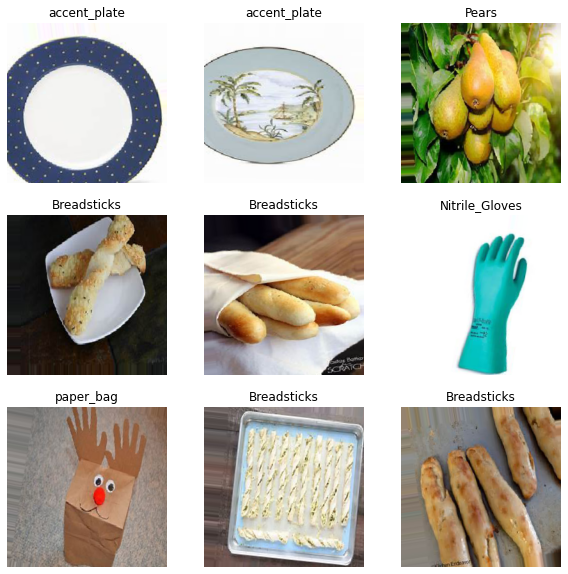

In [5]:
plt.figure(figsize=(10, 10))

images, labels = train_generator.next()

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i])
  plt.title(class_names[labels[i].argmax()])
  plt.axis("off")

## Create the model

#### AlexNet

In [6]:
def AlexNet(input_shape, num_classes, regl2 = 0.0001, lr=0.0001):
    model = Sequential()

    model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11),
                     strides=(2,4), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))    
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    model.add(Flatten())
    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)
    
    model.add(Dense(4096, input_shape=flatten_shape, activation='relu',
                    kernel_regularizer=regularizers.l2(regl2)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(regl2)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(regl2)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Dense(num_classes, activation='softmax'))

    adam = optimizers.Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

### Custom

In [7]:
def CustomNet(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(16, 3, input_shape=input_shape, padding='same', activation='relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())

    model.add(Dropout(0.4))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

### Model selection

In [8]:
model = "CustomNet" # CustomNet | AlexNet
num_classes = len(class_names)

if model == "CustomNet":
    model = CustomNet(input_shape, num_classes)
elif model == "AlexNet":
    model = AlexNet(input_shape, num_classes)
else:
    raise Exception("Model " + model + " is not valid")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0

### Train

In [9]:
epochs = 20
train_generator.reset()
steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps = val_generator.n // val_generator.batch_size + 1

history = model.fit(train_generator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=val_steps)

Epoch 1/20
179/179 [==============================] - 97s 528ms/step - loss: 2.5307 - accuracy: 0.2592 - val_loss: 1.3651 - val_accuracy: 0.5629
Epoch 2/20
179/179 [==============================] - 94s 524ms/step - loss: 1.4110 - accuracy: 0.5236 - val_loss: 1.2472 - val_accuracy: 0.5820
Epoch 3/20
179/179 [==============================] - 95s 531ms/step - loss: 1.2859 - accuracy: 0.5657 - val_loss: 1.2561 - val_accuracy: 0.5739
Epoch 4/20
179/179 [==============================] - 95s 530ms/step - loss: 1.1709 - accuracy: 0.6032 - val_loss: 1.1692 - val_accuracy: 0.6034
Epoch 5/20
179/179 [==============================] - 96s 534ms/step - loss: 1.1487 - accuracy: 0.6168 - val_loss: 1.1060 - val_accuracy: 0.6277
Epoch 6/20
179/179 [==============================] - 96s 536ms/step - loss: 1.0751 - accuracy: 0.6353 - val_loss: 1.0239 - val_accuracy: 0.6536
Epoch 7/20
179/179 [==============================] - 95s 533ms/step - loss: 1.0089 - accuracy: 0.6543 - val_loss: 1.0081 - val_ac

## Evaluate the model

In [10]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps = val_generator.n // val_generator.batch_size + 1

preds = model.predict(val_generator, verbose=1, steps=val_steps)

Y_pred = np.argmax(preds, axis=1)
Y_val = val_generator.classes  # shuffle=False in val_generator

print(classification_report(Y_val, Y_pred, labels=None, target_names=class_names, digits=3))

78/78 [==============================] - 6s 73ms/step
                    precision    recall  f1-score   support

       Breadsticks      0.765     0.728     0.746       313
       Cereals_box      0.569     0.884     0.692       344
Cocoa_drink_bottle      0.582     0.561     0.571       296
    Nitrile_Gloves      0.757     0.816     0.785       309
             Pears      0.824     0.765     0.793       306
      accent_plate      0.883     0.773     0.825       322
         paper_bag      0.775     0.583     0.666       355
      plastic_fork      0.782     0.650     0.710       226

          accuracy                          0.723      2471
         macro avg      0.742     0.720     0.724      2471
      weighted avg      0.741     0.723     0.724      2471



### Plot results

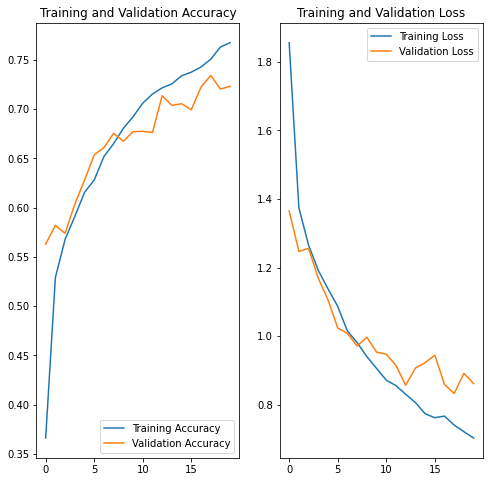

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()